While extracting the boundstate wavefunctions for matrix element calculations, we noticed that the wavefunctions are sometimes discontinuous at the boundaries, and vary erractically as a function of parameters. Here we report the discontinuity problem.

All the functions and boundstate codes are put at the back of the notebook for presentation purposes. We need to run those cells first before running the rest.

# Working case example

## Two-orbital boundstate w/ on-site Pauli matrices

Here we construct a system with two orbitals, gapped by sigma_x, y, and z in the leads. The purpose of selecting all three bases is to show that when non-commutating Pauli matrices are selected as basis for on-site elements, the boundstate wavefunctions are still well-behaved.

### System creation

In [1]:
import numpy as np
import kwant
from scipy import linalg
import matplotlib.colors as colors
np.set_printoptions(threshold=40)

In [9]:
params = dict(
    mu = 2.,
    A = 1,
    B_x=1,
    B_y=1,
    B_z=1
)

def make_system1(params, L=11):
    a = 1
    mu, A, B_x, B_y, B_z = params.values()
    
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    sigma_0 = np.array([[1, 0], [0, 1]])
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    
    ham = (2.*A/(a**2.)-mu)*sigma_0
    hop = -A/(a**2.)*sigma_0
    
    ham_leads = ham + B_x*sigma_x + B_y*sigma_y + B_z*sigma_z
    hop_leads = hop
    
    syst[(lat(-1))] = ham_leads
    syst[(lat(x) for x in range(0, L))] = ham
    syst[(lat(L))] = ham_leads
    syst[((lat(x), lat(x+1)) for x in range(-1, L))] = hop
    
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-2))] = ham_leads
    lead0[lat.neighbors()] = hop_leads
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L+1))] =  ham_leads
    lead1[lat.neighbors()] = hop_leads
    
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

syst = make_system1(params)

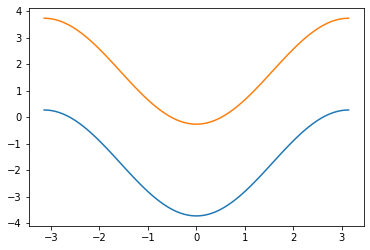

In [10]:
from matplotlib import pyplot as plt
bands=kwant.physics.Bands(syst.leads[1], params=params)
momenta=np.linspace(-np.pi,np.pi,101)
en=[bands(k) for k in momenta]
x=np.array(en)
en=(x)
plt.plot(momenta, en)
#plt.axhline(1.4)

### Scanning boundstate energies and extracting boundstate wavefunctions

We scan the boundstate energies using the Weston version due to its solver being better implemented and more efficient. We then re-import the energies back into the Istas version to calculate the lead wavefunctions beyond the j=0 unit cell, which we cannot do in the Weston version due to the evanescent modes being saved as Schur vectors rather than eigenvectors (conversion to latter requires changing the kwant.modes source code).

In [11]:
energies, wavefunctions = find_boundstates(syst, -4, 4, rtol=1e-2, params=params)

In [12]:
energies

array([-2.30833431, -1.94025026, -1.76469903, -1.63067309, -1.4843453 ,
       -1.11739914, -0.82088082, -0.69059751, -0.27181163, -0.16712528,
        0.16712528,  0.27181163,  0.69059751,  0.82088082,  1.11739914,
        1.4843453 ,  1.63067309,  1.76469903,  1.94025026,  2.30833431])

0
[-2.30833431 -2.30833431]
0.3673049643878748
1
[-1.94025026 -1.94025026]
2
[-1.76469903 -1.76469903]
3
[-1.63067309 -1.63067309]
0.13334578733990182
4
[-1.4843453 -1.4843453]
5
[-1.11739914 -1.11739914]
6
[-0.82088082 -0.82088082]
0.12677852082424607
7
[-0.69059751 -0.69059751]
8
[-0.27181163 -0.27181163]
9
[-0.16712528 -0.16712528]
0.2377325665704427
10
[0.16712528 0.16712528]
0.23773256657044267
11
[0.27181163 0.27181163]
12
[0.69059751 0.69059751]
13
[0.82088082 0.82088082]
0.12677852082424632
14
[1.11739914 1.11739914]
15
[1.4843453 1.4843453]
16
[1.63067309 1.63067309]
0.13334578733990193
17
[1.76469903 1.76469903]
18
[1.94025026 1.94025026]
19
[2.30833431 2.30833431]
0.36730496438787524
0.3673049643878748
0.13334578733990182
0.12677852082424607
0.2377325665704427
0.23773256657044267
0.12677852082424632
0.13334578733990193
0.36730496438787524


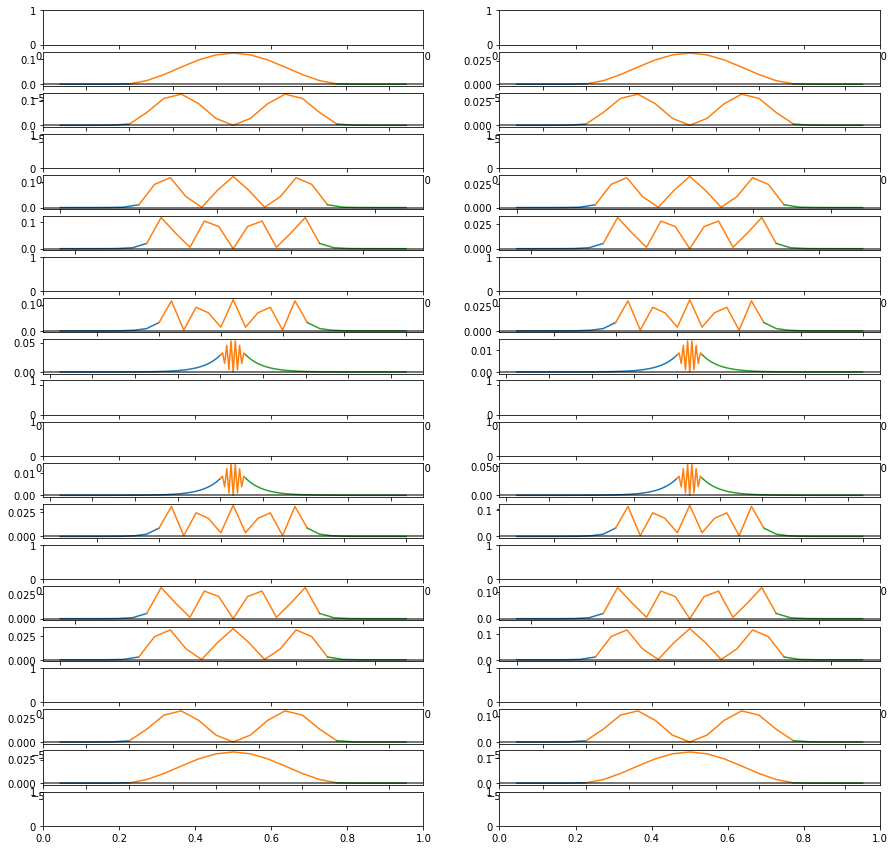

In [13]:
e_compare, wavefunc_lleads, wavefunc_rleads, wavefunc_scat, no_cells_lleads, no_cells_rleads = istas_scan(energies, syst, params=params, all_out=True)

In [14]:
np.array(e_compare)

array([-1.94025026, -1.76469903, -1.4843453 , -1.11739914, -0.69059751,
       -0.27181163,  0.27181163,  0.69059751,  1.11739914,  1.4843453 ,
        1.76469903,  1.94025026])

Some solutions from the Weston version are clearly unphysical, and hence not reproduced by the Istas version which follows the original paper better. One example is the state at energy=-0.16712528, the mode decomposition at which energy reveals there are 0 evanescent modes, and hence impossible to be a boundstate.

The physical solutions that are obtained also from the Istas version matches with those obtained from the Weston version up to different normalisation, which is expected since kwant.modes normalises states to be unit current, while Istas nromalises them to be unit probability.

All the physical solutions are continuous, and give particle-in-a-box like solutions as expected.

### Comparing Istas and Weston wavefunctions

In [15]:
# Weston scat wavefunction / Istas scat wavefuntion at energy=-1.94
wavefunctions[:,1]/wavefunc_scat[0].flatten()

array([-0.21669613+0.97402677j, -0.21669613+0.97402677j,
       -0.21669613+0.97402677j, -0.21669613+0.97402677j,
       -0.21669613+0.97402677j, -0.21669613+0.97402677j,
       -0.21669613+0.97402677j, -0.21669613+0.97402677j,
       -0.21669613+0.97402677j, -0.21669613+0.97402677j,
       -0.21669613+0.97402677j, -0.21669613+0.97402677j,
       -0.21669613+0.97402677j, -0.21669613+0.97402677j,
       -0.21669613+0.97402677j, -0.21669613+0.97402677j,
       -0.21669613+0.97402677j, -0.21669613+0.97402677j,
       -0.21669613+0.97402677j, -0.21669613+0.97402677j,
       -0.21669613+0.97402677j, -0.21669613+0.97402677j,
       -0.21669613+0.97402677j, -0.21669613+0.97402677j,
       -0.21669613+0.97402677j, -0.21669613+0.97402677j])

In [16]:
# All parts of the wavefunctions from Istas added together gives 1, as expected.
np.sum(np.abs(wavefunc_scat[0].flatten())**2.)+np.sum(np.abs(wavefunc_lleads[0][2:])**2.)+np.sum(np.abs(wavefunc_rleads[0][2:])**2.)

0.9999999999999999

The same continuity between scattering region and leads are observed in the Weston wavefunctions as well. However, due to the evanescent modes usually being stored as Schur rather than eigenvectors, we only calculate the wavefunction at j=0 cells and see if it agrees with the last unit cell in the scattering region. It does in this working example.

In [17]:
weston_psi = extract_boundstates(syst, energy=energies[1], params=params)

In [18]:
# transform vecs and vecslmbdainv to "eigenvectors" based on https://gitlab.kwant-project.org/kwant/kwant/-/merge_requests/39
vecslmbdainv, vecs = vecs_vecslmbdainv(syst, energies[1], params, lead_no=1)
phi, phi_lmbda = inverse_A_B_alt(syst, vecslmbdainv, vecs, params)

In [19]:
#j=0 unit cell in right lead
phi@weston_psi[-1:]

array([[0.03437006-0.00717923j],
       [0.0152081 +0.00995253j]])

In [20]:
# last unit cell in scattering region
weston_psi[-4:-2]

array([[0.03437006-0.00717923j],
       [0.0152081 +0.00995253j]])

This shows that in working cases, both the Weston and Istas implementations work as intended. As presented below, in non-working cases, the Istas implementation has problems with wavefunction continuity.

### Diagonal matrix elements

Here we validate that the Istas wavefunctions are the energy eigenstates of the total (leads+scat) system Hamiltonian.

In [21]:
def finite_system1(params, L_leads, L=11):
    a = 1
    mu, A, B_x, B_y, B_z = params.values()
    L_leads = int(L_leads)
    
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    sigma_0 = np.array([[1, 0], [0, 1]])
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    
    ham = (2.*A/(a**2.)-mu)*sigma_0
    hop = -A/(a**2.)*sigma_0
    
    ham_leads = ham + B_x*sigma_x + B_y*sigma_y + B_z*sigma_z
    hop_leads = hop
    
    syst[(lat(x) for x in range(-L_leads, 0))] = ham_leads
    syst[(lat(x) for x in range(0, L))] = ham
    syst[(lat(x) for x in range(L, L_leads+L))] = ham_leads
    syst[((lat(x), lat(x+1)) for x in range(-L_leads, L_leads+L-1))] = hop

    return syst.finalized()

In [22]:
normalisation_check = []
eigenenergy_check = []
finite_syst1 = finite_system1(params, no_cells_lleads[0])
for i in range(len(wavefunc_scat)):
    wavefunc_left_temp = np.c_[wavefunc_lleads[i][2:][::2][::-1], wavefunc_lleads[i][2:][1::2][::-1]].flatten()
    psi0 = np.r_[wavefunc_left_temp, wavefunc_scat[i].flatten(), wavefunc_lleads[i][2:]]
    norm = psi0.T.conj()@psi0
    eigenenergy = psi0.T.conj()@finite_syst1.hamiltonian_submatrix()@psi0
    normalisation_check.append(norm)
    eigenenergy_check.append(eigenenergy)

In [23]:
normalisation_check

[(0.9999999999999998+0j),
 (0.9999999999999999+0j),
 (0.9999999999999998+0j),
 (1+0j),
 (1.0000000000000002+0j),
 (0.9951142601207325+0j),
 (0.9951142601207315+0j),
 (0.9999999999999998+0j),
 (1+0j),
 (1+0j),
 (1.0000000000000002+0j),
 (1+0j)]

In [24]:
np.real(eigenenergy_check)

array([-1.94025026, -1.75683031, -1.4843453 , -1.07619017, -0.69059751,
       -0.13322924,  0.13322924,  0.69059751,  1.07619017,  1.4843453 ,
        1.75683031,  1.94025026])

In [25]:
e_compare

[-1.9402502594652855,
 -1.7646990264319466,
 -1.4843452974354765,
 -1.1173991401151413,
 -0.690597510124125,
 -0.27181163437275924,
 0.2718116343727586,
 0.6905975101241248,
 1.117399140115141,
 1.4843452974354765,
 1.7646990264319466,
 1.9402502594652853]

The deviations between eigenenergy_check, which is calculated by psi^dagger H psi, and e_compare, the Istas boundstate energies is because of deviations at certain sites. Two of them happen at the edge of the finite system, which we expect since the lead wavefunctions are calculated assuming translational invariance. At some energy levels, however, there are deviations at other sites, which do not seem physical. Below are two examples (e=-1.940, e=-0.272) illustrating what we wrote above.

e=-1.940

In [26]:
finite_syst1 = finite_system1(params, no_cells_lleads[0])

In [27]:
ind=0
wavefunc_left_temp = np.c_[wavefunc_lleads[ind][2:][::2][::-1], wavefunc_lleads[ind][2:][1::2][::-1]].flatten()
psi0 = np.r_[wavefunc_left_temp, wavefunc_scat[ind].flatten(), wavefunc_lleads[ind][2:]]

In [28]:
(finite_syst1.hamiltonian_submatrix()@psi0)/psi0

array([-1.64405063-1.08600773e-15j, -1.64405063+1.75478971e-15j,
       -1.94025026-1.13894570e-15j, ..., -1.94025026+1.29942016e-15j,
       -1.64405063-1.08600773e-15j, -1.64405063+1.75478971e-15j])

(H@psi)/psi, where / is entry by entry division. We expect to see the eigenvalue -1.940 everywhere. This does not happen only at the edge of the finite system, as it is missing hopping from the L+1 site for correction. So this wavefunction behaves as expected. We can mark the index of the unit cells where (H@psi)/psi deviates from E (inndex 0 marks the first scattering region site. Lead wavefunctions are all 39 unit cells long for this Hamiltonian)

In [29]:
ind=0
sth = np.abs((finite_syst1.hamiltonian_submatrix()@psi0)/psi0)+e_compare[ind]
((np.where(np.around(sth, 2)!=0)[0]+1)[1::2]/2)-(no_cells_lleads[0]+1)

array([-39.,  49.])

e=-0.272

In [30]:
ind=5
wavefunc_left_temp = np.c_[wavefunc_lleads[ind][2:][::2][::-1], wavefunc_lleads[ind][2:][1::2][::-1]].flatten()
psi0 = np.r_[wavefunc_left_temp, wavefunc_scat[ind].flatten(), wavefunc_lleads[ind][2:]]

In [31]:
(finite_syst1.hamiltonian_submatrix()@psi0)/psi0

array([ 0.66794104-4.06314456e-15j,  0.66794104-2.26324274e-15j,
       -0.27181163-7.24155439e-16j, ..., -0.27181163+9.41409628e-16j,
        0.66794104-4.06314456e-15j,  0.66794104-2.11483338e-15j])

In [32]:
ind=5
sth = np.real((finite_syst1.hamiltonian_submatrix()@psi0)/psi0)-e_compare[ind]
((np.where(np.around(sth, 2)!=0)[0]+1)[1::2]/2)-(no_cells_lleads[0]+1)

array([-39.,   5.,  11.,  12.,  49.])

For this energy state, deviation occurs not only at the end of the finite leads, but also in the middle and near the edge of the scattering region. The deviation is also assymetric about the centre of the finite system, which again is problematic since the system has inversion symmetry.

We look at where the deviations occur for all 12 states.

In [33]:
deviation_index_array = []
for i in range(len(e_compare)):
    ind=i
    wavefunc_left_temp = np.c_[wavefunc_lleads[ind][2:][::2][::-1], wavefunc_lleads[ind][2:][1::2][::-1]].flatten()
    psi0 = np.r_[wavefunc_left_temp, wavefunc_scat[ind].flatten(), wavefunc_lleads[ind][2:]]
    sth = np.real((finite_syst1.hamiltonian_submatrix()@psi0)/psi0)-e_compare[ind]
    deviation_index_array.append(((np.where(np.around(sth, 2)!=0)[0]+1)[1::2]/2)-(no_cells_lleads[0]+1))

In [34]:
deviation_index_array

[array([-39.,  49.]),
 array([-39.,   5.,  11.,  12.,  49.]),
 array([-39.,  49.]),
 array([-39.,   5.,  11.,  12.,  49.]),
 array([-39.,  49.]),
 array([-39.,   5.,  11.,  12.,  49.]),
 array([-39.,   5.,  11.,  12.,  49.]),
 array([-39.,  49.]),
 array([-39.,   5.,  11.,  12.,  49.]),
 array([-39.,  49.]),
 array([-39.,   5.,  11.,  12.,  49.]),
 array([-39.,  49.])]

Deviations from local Schrodinger's equation for even parity boundstate solutions. This corroborates the fact that for even parity solutions psi^dagger@H@psi deviates from E much more than for odd parity solutions. Bug in my code? Direction of hopping in the finite system different from that in the infinite system?

In [45]:
mode_no = []
for i in range(len(energies)):
    _, stab = syst.leads[1].modes(energies[i])
    svd_v = stab.sqrt_hop
    evan_vecs = slice(2 * stab.nmodes, None)
    u_out = stab.vecs[:, evan_vecs]
    ulinv_out = stab.vecslmbdainv[:, evan_vecs]
    mode_no.append(stab.nmodes)

In [46]:
mode_no

[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Non-Working case example

## Two-orbital BdG

We encounter some major problems when we try to implement the simplest BdG Hamiltonian: (-mu+A k_x^2) tau_z + Delta tau_x. Compare to the previous case, where we have a B field splitting and mixing the two spin states, the only difference is that the hopping not has a sigma_z basis. However, If the Hamiltonian only has the (-mu+A*k_x^2)*tau_z term, it will still be well-behaved as above. This is the simplest case we have managed to reduce to to capture the faulty problems we have encountered in more involved models.

### System creation

In [47]:
params = dict(
    mu = 0.,
    A = 1,
    Delta=1e-3
)

def make_system1(params, L=11):
    a = 1
    mu, A, Delta = params.values()
    
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    sigma_0 = np.array([[1, 0], [0, 1]])
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    
    ham = (2.*A/(a**2.)-mu)*sigma_z
    hop = -A/(a**2.)*sigma_z
    
    ham_leads = ham + Delta*sigma_x
    hop_leads = hop
    
    syst[(lat(-1))] = ham_leads
    syst[(lat(x) for x in range(0, L))] = ham
    syst[(lat(L))] = ham_leads
    syst[((lat(x), lat(x+1)) for x in range(-1, L))] = hop
    
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-2))] = ham_leads
    lead0[lat.neighbors()] = hop_leads
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L+1))] =  ham_leads
    lead1[lat.neighbors()] = hop_leads
    
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

syst = make_system1(params)

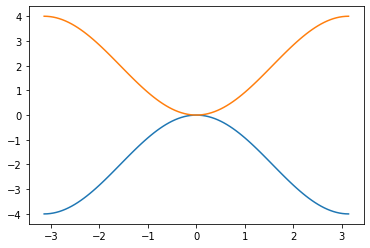

In [48]:
from matplotlib import pyplot as plt
bands=kwant.physics.Bands(syst.leads[1], params=params)
momenta=np.linspace(-np.pi,np.pi,101)
en=[bands(k) for k in momenta]
x=np.array(en)
en=(x)
plt.plot(momenta, en)
#plt.axhline(1.4)

### Scanning boundstate energies and extracting boundstate wavefunctions

In [49]:
energies, wavefunctions = find_boundstates(syst, -2e-3, 2e-3, rtol=1e-5, params=params)

In [50]:
energies

array([-0.00092758,  0.00092758])

In [ ]:
0.9863329-0.01348157j

0
[-0.00092758 -0.00092758]
1
[0.00092758 0.00092758]


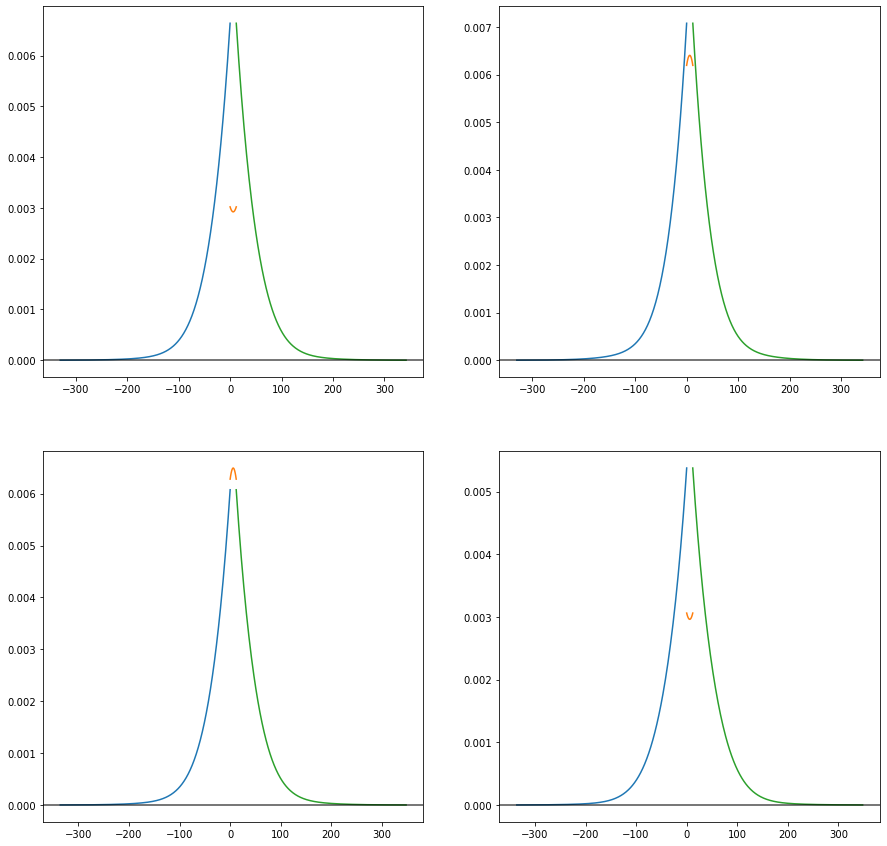

In [78]:
e_compare, wavefunc_lleads, wavefunc_rleads, wavefunc_scat, no_cells_lleads, no_cells_rleads = istas_scan(energies, syst, params=params, all_out=True)

In [52]:
np.array(e_compare)

array([-0.00092758,  0.00092758])

### The wavefunctions are now discontinuous. Moreover, the lead part of the wavefunctions of the two states does not seem to observe PHS.

### Comparing Istas and Weston wavefunctions

In [53]:
# Weston scat wavefunction / Istas scat wavefuntion at energy=-0.00092758
wavefunctions[:,0]/wavefunc_scat[0].flatten()

array([0.39177437+2.47140243j, 0.39177437+2.47140243j,
       0.39177437+2.47140243j, 0.39177437+2.47140243j,
       0.39177437+2.47140243j, 0.39177437+2.47140243j,
       0.39177437+2.47140243j, 0.39177437+2.47140243j,
       0.39177437+2.47140243j, 0.39177437+2.47140243j,
       0.39177437+2.47140243j, 0.39177437+2.47140243j,
       0.39177437+2.47140243j, 0.39177437+2.47140243j,
       0.39177437+2.47140243j, 0.39177437+2.47140243j,
       0.39177437+2.47140243j, 0.39177437+2.47140243j,
       0.39177437+2.47140243j, 0.39177437+2.47140243j,
       0.39177437+2.47140243j, 0.39177437+2.47140243j,
       0.39177437+2.47140243j, 0.39177437+2.47140243j,
       0.39177437+2.47140243j, 0.39177437+2.47140243j])

In [54]:
# The wavefunctions, despite having gone through the normalisation procedures detailed in the appendix of Istas et al.
# do not sum to 1 in real space.
np.sum(np.abs(wavefunc_scat[0].flatten())**2.)+np.sum(np.abs(wavefunc_lleads[0][2:])**2.)+np.sum(np.abs(wavefunc_rleads[0][2:])**2.)

1.0867191590413185

Checking Weston

In [55]:
weston_psi = extract_boundstates(syst, energy=energies[0], params=params)

In [56]:
weston_psi.flatten()[:26]/wavefunctions[:,0]

array([-0.35027863-0.93664555j, -0.35027863-0.93664555j,
       -0.35027863-0.93664555j, -0.35027863-0.93664555j,
       -0.35027863-0.93664555j, -0.35027863-0.93664555j,
       -0.35027863-0.93664555j, -0.35027863-0.93664555j,
       -0.35027863-0.93664555j, -0.35027863-0.93664555j,
       -0.35027863-0.93664555j, -0.35027863-0.93664555j,
       -0.35027863-0.93664555j, -0.35027863-0.93664555j,
       -0.35027863-0.93664555j, -0.35027863-0.93664555j,
       -0.35027863-0.93664555j, -0.35027863-0.93664555j,
       -0.35027863-0.93664555j, -0.35027863-0.93664555j,
       -0.35027863-0.93664555j, -0.35027863-0.93664555j,
       -0.35027863-0.93664555j, -0.35027863-0.93664555j,
       -0.35027863-0.93664555j, -0.35027863-0.93664555j])

In [57]:
wavefunctions[:,0]

array([ 0.02153053+0.1358195j , -0.03083302-0.19450177j,
        0.02142199+0.13513483j, -0.03099225-0.19550619j,
        0.02133333+0.13457551j, -0.03112272-0.19632927j,
        0.02126445+0.13414103j, -0.03122433-0.19697023j,
        0.0212153 +0.13383096j, -0.03129697-0.19742848j,
        0.02118583+0.13364504j, -0.03134059-0.1977036j ,
        0.02117601+0.13358309j, -0.03135513-0.19779534j,
        0.02118583+0.13364504j, -0.03134059-0.1977036j ,
        0.0212153 +0.13383096j, -0.03129697-0.19742848j,
        0.02126445+0.13414103j, -0.03122433-0.19697023j,
        0.02133333+0.13457551j, -0.03112272-0.19632927j,
        0.02142199+0.13513483j, -0.03099225-0.19550619j,
        0.02153053+0.1358195j , -0.03083302-0.19450177j])

In [62]:
# transform vecs and vecslmbdainv to "eigenvectors" based on https://gitlab.kwant-project.org/kwant/kwant/-/merge_requests/39
vecslmbdainv, vecs = vecs_vecslmbdainv(syst, energies[0], params, lead_no=1)
phi, phi_lmbda = inverse_A_B_alt(syst, vecslmbdainv, vecs, params)

In [63]:
phi_lmbda/phi

array([[0.98900859+0.j, 0.91840549+0.j],
       [0.98378235-0.j, 1.05759309+0.j]])

In [64]:
#j=0 unit cell in right lead
phi@weston_psi[-2:]

array([[ 0.11967305-0.06774114j],
       [-0.17137907+0.09700943j]])

In [61]:
# last unit cell in scattering region
weston_psi[-6:-4]

array([[ 0.11967305-0.06774114j],
       [-0.17137907+0.09700943j]])

Weston wavefunctions seem to be continuous.

### Diagonal matrix elements

In [65]:
def finite_system1(params, L_leads, L=11):
    a = 1
    mu, A, Delta = params.values()
    L_leads = int(L_leads)
    
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    sigma_0 = np.array([[1, 0], [0, 1]])
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])
    
    ham = (2.*A/(a**2.)-mu)*sigma_z
    hop = -A/(a**2.)*sigma_z
    
    ham_leads = ham + Delta*sigma_x
    hop_leads = hop
    
    syst[(lat(x) for x in range(-L_leads, 0))] = ham_leads
    syst[(lat(x) for x in range(0, L))] = ham
    syst[(lat(x) for x in range(L, L_leads+L))] = ham_leads
    syst[((lat(x), lat(x+1)) for x in range(-L_leads, L_leads+L-1))] = hop

    return syst.finalized()

In [66]:
normalisation_check = []
eigenenergy_check = []
finite_syst1 = finite_system1(params, no_cells_lleads[0])
for i in range(len(wavefunc_scat)):
    wavefunc_left_temp = np.c_[wavefunc_lleads[i][2:][::2][::-1], wavefunc_lleads[i][2:][1::2][::-1]].flatten()
    psi0 = np.r_[wavefunc_left_temp, wavefunc_scat[i].flatten(), wavefunc_lleads[i][2:]]
    norm = psi0.T.conj()@psi0
    eigenenergy = psi0.T.conj()@finite_syst1.hamiltonian_submatrix()@psi0
    normalisation_check.append(norm)
    eigenenergy_check.append(eigenenergy)

In [67]:
normalisation_check

[(1.0867191590413132+0j), (0.9899534838777002+0j)]

In [68]:
np.real(eigenenergy_check)

array([-0.00111328,  0.00252872])

In [69]:
e_compare

[-0.0009275841974067285, 0.0009275841974065175]

e=-0.0009

In [70]:
finite_syst1 = finite_system1(params, no_cells_lleads[0])

In [71]:
no_cells_lleads[0]

169.0

In [72]:
ind=0
wavefunc_left_temp = np.c_[wavefunc_lleads[ind][2:][::2][::-1], wavefunc_lleads[ind][2:][1::2][::-1]].flatten()
psi0 = np.r_[wavefunc_left_temp, wavefunc_scat[ind].flatten(), wavefunc_lleads[ind][2:]]

In [73]:
(finite_syst1.hamiltonian_submatrix()@psi0)/psi0

array([ 9.86505048e-01-1.56267925e-02j, -9.89457820e-01+1.41364446e-02j,
       -9.27584197e-04-2.80901954e-16j, ...,
       -9.27584197e-04+4.85091496e-16j,  9.86505048e-01-1.56267925e-02j,
       -9.89457820e-01+1.41364446e-02j])

In [74]:
ind=0
sth = np.abs((finite_syst1.hamiltonian_submatrix()@psi0)/psi0)+e_compare[ind]
((np.where(np.around(sth, 2)!=0)[0]+1)[1::2]/2)-(no_cells_lleads[0]+1)

array([-169.,   -2.,   -1.,   11.,   12.,  179.])

Deviations at edges of leads, and boundaries between leads and scattering region.

e=0.0009

In [75]:
ind=1
wavefunc_left_temp = np.c_[wavefunc_lleads[ind][2:][::2][::-1], wavefunc_lleads[ind][2:][1::2][::-1]].flatten()
psi0 = np.r_[wavefunc_left_temp, wavefunc_scat[ind].flatten(), wavefunc_lleads[ind][2:]]

In [76]:
(finite_syst1.hamiltonian_submatrix()@psi0)/psi0

array([ 9.88569730e-01+1.56799307e-02j, -9.84644280e-01-1.59472010e-02j,
        9.27584197e-04+2.91356415e-16j, ...,
        9.27584197e-04-1.63649690e-16j,  9.88569730e-01+1.56799307e-02j,
       -9.84644280e-01-1.59472010e-02j])

In [77]:
ind=1
sth = np.real((finite_syst1.hamiltonian_submatrix()@psi0)/psi0)-e_compare[ind]
((np.where(np.around(sth, 2)!=0)[0]+1)[1::2]/2)-(no_cells_lleads[0]+1)

array([-169.,   -2.,   -1.,   11.,   12.,  179.])

# Functions

In [4]:
# code chunk useful for selecting every n elements to separate the wavefunctions in the two leads.
def select_in_groups_strided(a, M, N): # Keep first M, delete next N and so on.
    K = M+N
    na = a.size
    nrows = (1+((na-1)//K))
    n = a.strides[0]
    out = np.lib.index_tricks.as_strided(a, shape=(nrows,K), strides=(K*n,n))
    N = M*(na//K) + (na - (K*(na//K)))
    return out[:,:M].ravel()[:N]

In [5]:
#returns the wavefunction in the leads up to a given last-cell magnitude, or a given number of cells.
def long_wf_in_leads(q_e, L_out, Phi, lead_no=1, fixed_no_cells=None, limit=100., no_orb=2):
    '''return wavefunction with leads with number of unit cells'''
    no_orb = int(no_orb)
    if fixed_no_cells is None:
        j=0
        quick_wf = wf_in_leads(q_e, L_out, Phi, 0)
        wave_func_array = quick_wf
        first_site_amplitude = quick_wf.T.conj()@quick_wf
        last_site_amplitude = first_site_amplitude
        while last_site_amplitude > first_site_amplitude/limit:
            j+=1
            quick_wfj = wf_in_leads(q_e, L_out, Phi, j)
            wave_func_array = np.vstack((wave_func_array, quick_wfj))
            last_site_amplitude = quick_wfj.T.conj()@quick_wfj
        wave_func_array = np.array(wave_func_array)
        if lead_no==0:
            return select_in_groups_strided(wave_func_array, no_orb, no_orb), wave_func_array.shape[0]/(no_orb*2)
        elif lead_no==1:
            return select_in_groups_strided(wave_func_array[no_orb:], no_orb, no_orb), wave_func_array.shape[0]/(no_orb*2)
    else:
        wave_func_array = wf_in_leads(q_e, L_out, Phi, 0)
        for i in range(0, fixed_no_cells):
            quick_wfj = wf_in_leads(q_e, L_out, Phi, i+1)
            wave_func_array = np.vstack((wave_func_array, quick_wfj))
        wave_func_array = np.array(wave_func_array)
        if lead_no==0:
            return select_in_groups_strided(wave_func_array, no_orb, no_orb), wave_func_array.shape[0]/(no_orb*2)
        elif lead_no==1:
            return select_in_groups_strided(wave_func_array[no_orb:], no_orb, no_orb), wave_func_array.shape[0]/(no_orb*2)

In [6]:
# re-inputs the boundstate energies into the Istas version boundstate code to extract lead wavefunctions.
# has a plot function inside to visualise the overall wavefunction of each state in each orbital.
# code not optimised. Only for showing the problem we have encountered with the algorithm.
def istas_scan(e_subarray, syst, params=None, all_out=False, no_orb=2):
    no_orb = int(no_orb)
    no_states = len(e_subarray)
    e_division = np.array([[e_subarray[i], e_subarray[i]] for i in range(len(e_subarray))])
    e_compare = []
    wavefunc_lleads = []
    no_cells_lleads = []
    wavefunc_rleads = []
    no_cells_rleads = []
    wavefunc_scat = []
    fig, axs = plt.subplots(no_states, 2, figsize=(15,15))
    for i in range(len(e_subarray)):
        print(i)
        print(e_division[i])
        try:
            E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, e_division[i], return_wf=True, params=params)
        except:
            continue
        e_compare.append(E)
        wavefunc_scat.append(psi_alpha_0)
        trial_wfr, no_cellsr = long_wf_in_leads(q_e, L_out, Phi, lead_no=1, limit=10000., no_orb=no_orb)
        trial_wfl, no_cellsl = long_wf_in_leads(q_e, L_out, Phi, lead_no=0, limit=10000., no_orb=no_orb)
        no_cells_lleads.append(no_cellsl)
        no_cells_rleads.append(no_cellsr)
        wavefunc_lleads.append(trial_wfl)
        wavefunc_rleads.append(trial_wfr)
        #print(trial_wf)
        #print(trial_wfr)
        #print(trial_wfr.shape)
        #print(trial_wfr.shape[0]/8)
        #print(psi_alpha_0.shape)
        for k in range(no_orb):
            ax = axs[i][k]
            ax.plot(np.arange(-trial_wfl.shape[0]/no_orb+1, 1), np.array([np.abs(trial_wfl[j*no_orb+k])**2. for j in range(int(trial_wfl.shape[0]/no_orb)-1, -1, -1)]))
                #[trial_wfl[j*no_orb:(j+1)*no_orb].T.conj()@trial_wfl[j*no_orb:(j+1)*no_orb] for j in range(int(trial_wfl.shape[0]/no_orb)-1, -1, -1)]))
            ax.plot(np.arange(psi_alpha_0.shape[0]/no_orb), np.array([np.abs(psi_alpha_0[j*no_orb+k,0])**2. for j in range(int(psi_alpha_0.shape[0]/no_orb))]))
                #psi_alpha_0[j*no_orb:(j+1)*no_orb,0].T.conj()@psi_alpha_0[j*no_orb:(j+1)*no_orb,0] for j in range(int(psi_alpha_0.shape[0]/no_orb))]))
            ax.plot(np.arange(psi_alpha_0.shape[0]/no_orb-1, trial_wfr.shape[0]/no_orb+psi_alpha_0.shape[0]/no_orb-1), np.array([np.abs(trial_wfr[j*no_orb+k])**2. for j in range(int(trial_wfr.shape[0]/no_orb))]))
            #ax.plot(np.arange(-trial_wfl.shape[0]/8+1, 0), np.array([np.abs(trial_wfl[j*8+k])**2. for j in range(int(trial_wfl.shape[0]/8)-1, 0, -1)]))
            #ax.plot(np.arange(psi_alpha_0.shape[0]/8), np.array([np.abs(psi_alpha_0[j*8+k,0])**2. for j in range(int(psi_alpha_0.shape[0]/8))]))
            #ax.plot(np.arange(psi_alpha_0.shape[0]/8, trial_wfr.shape[0]/8+psi_alpha_0.shape[0]/8-1), np.array([np.abs(trial_wfr[j*8+k])**2. for j in range(int(trial_wfr.shape[0]/8)-1)]))
            #plt.xlim(-100, 100)
            #plt.ylim(0, 0.002)
            ax.axhline(0, c='k', alpha=0.7)
        
        '''if i==0:
            fig, axs = plt.subplots(4, 2, figsize=(15,15))
            for k in range(0, 8):
                ax = axs.flatten()[k]
                ax.plot(np.arange(-trial_wfl.shape[0]/8+1, 0), np.array([np.abs(trial_wfl[j*8+k])**2. for j in range(int(trial_wfl.shape[0]/8)-1, 0, -1)]))
                ax.plot(np.arange(psi_alpha_0.shape[0]/8), np.array([np.abs(psi_alpha_0[j*8+k,0])**2. for j in range(int(psi_alpha_0.shape[0]/8))]))
                ax.plot(np.arange(psi_alpha_0.shape[0]/8, trial_wfr.shape[0]/8+psi_alpha_0.shape[0]/8-1), np.array([np.abs(trial_wfr[j*8+k])**2. for j in range(int(trial_wfr.shape[0]/8)-1)]))
                #plt.xlim(-100, 100)
                #plt.ylim(0, 0.002)
                ax.axhline(0, c='k', alpha=0.7)
            print('left lead')
            print(np.array([trial_wfl[j*1:(j+1)*1].T.conj()@trial_wfl[j*1:(j+1)*1] for j in range(int(trial_wfl.shape[0]/1)-1, -1, -1)]))
            plt.plot(np.arange(-trial_wfl.shape[0]/1+1, 1), np.array([trial_wfl[j*1:(j+1)*1].T.conj()@trial_wfl[j*1:(j+1)*1] for j in range(int(trial_wfl.shape[0]/1)-1, -1, -1)]))
            plt.plot(np.arange(psi_alpha_0.shape[0]/1), np.array([psi_alpha_0[j*1:(j+1)*1,0].T.conj()@psi_alpha_0[j*1:(j+1)*1,0] for j in range(int(psi_alpha_0.shape[0]/1))]))
            plt.plot(np.arange(psi_alpha_0.shape[0]/1-1, trial_wfr.shape[0]/1+psi_alpha_0.shape[0]/1-1), np.array([trial_wfr[j*1:(j+1)*1].T.conj()@trial_wfr[j*1:(j+1)*1] for j in range(int(trial_wfr.shape[0]/1))]))
            #plt.xlim(-100, 100)'''
        #print(psi_alpha_0[-8:])
        #print(wf_in_leads(q_e, L_out, Phi, 0)[-8:])
        #print(syst.leads[1].inter_cell_hopping().T.conj()@psi_alpha_0[-8:])
        #print(psi_alpha_0[-8:]/wf_in_leads(q_e, L_out, Phi, 0)[-8:])
        #print(i)
        #print(E)
        #print(psi_alpha_0)
        #print(q_e)
        #print(np.abs(np.array([L_out[i,i] for i in range(len(L_out))])))
        #print(Phi[:,3])
    
    #print(no_cells_rleads)
    no_cell_runiform = int(max(no_cells_rleads)/2)
    #print('no_cell_runiform')
    #print(no_cell_runiform)
    e_compare = []
    wavefunc_lleads = []
    no_cells_lleads = []
    wavefunc_rleads = []
    no_cells_rleads = []
    wavefunc_scat = []
    for i in range(len(e_subarray)):
        #print(i)
        #print(e_division[i])
        try:
            E, psi_alpha_0, q_e, L_out, Phi = bound_state(syst, e_division[i], return_wf=True, params=params)
        except:
            continue
        e_compare.append(E)
        wavefunc_scat.append(psi_alpha_0)
        trial_wfr, no_cellsr = long_wf_in_leads(q_e, L_out, Phi, lead_no=1, fixed_no_cells=no_cell_runiform, no_orb=no_orb)
        trial_wfl, no_cellsl = long_wf_in_leads(q_e, L_out, Phi, lead_no=0, fixed_no_cells=no_cell_runiform, no_orb=no_orb)
        no_cells_lleads.append(no_cellsl)
        no_cells_rleads.append(no_cellsr)
        wavefunc_lleads.append(trial_wfl)
        wavefunc_rleads.append(trial_wfr)
    
    if all_out:
        return e_compare, wavefunc_lleads, wavefunc_rleads, wavefunc_scat, no_cells_lleads, no_cells_rleads
    else:
        return e_compare, wavefunc_rleads, no_cells_rleads

In [7]:
# transform from vecs and vecslmbdainv of kwant.modes to eigenvectors@eigenvalues and eigevectors following
# https://gitlab.kwant-project.org/kwant/kwant/-/merge_requests/39
def inverse_A_B_alt(syst, vecslmbdainv, vecs, params):
    hop = syst.leads[0].inter_cell_hopping(params=params)
    B = np.sqrt(np.linalg.norm(hop))*np.identity(hop.shape[0])
    A = hop@np.linalg.inv(B).T.conj()
    B_dagger_inv = np.linalg.inv(B.T.conj())
    A_dagger_inv = np.linalg.inv(A.T.conj())
    phi_lmbda = A_dagger_inv@vecs
    phi = B_dagger_inv@vecslmbdainv
    return phi, phi_lmbda

In [8]:
# Get StabilisedModes given system and energy
def vecs_vecslmbdainv(syst, energy, params, lead_no=1):
    _, stab = syst.leads[lead_no].modes(energy, params=params)
    evan_vecs = slice(2 * stab.nmodes, None)
    u_out = stab.vecs[:, evan_vecs]
    ulinv_out = stab.vecslmbdainv[:, evan_vecs]
    return ulinv_out, u_out

# Boundstate algorithms

This is the feature version due to Joseph Weston taken from https://gitlab.kwant-project.org/jbweston/kwant/-/blob/feature/boundstate/kwant/physics/boundstate.py This version of the boundstate algorithm, albeit it has a lot of internal functions and was a little bit more opaque to look into, has a much more efficient root finder than the original version due to Mathieu Istas, posted below. We calculate the boundstate energies in our system using these methods first. In order to construct lead wavefunctions beyond the first unit cell, we then put the energies into the Istas version.

In [2]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

# This is the feature version due to Joseph Weston taken from
#https://gitlab.kwant-project.org/jbweston/kwant/-/blob/feature/boundstate/kwant/physics/boundstate.py
#This version of the boundstate algorithm, albeit it has a lot of internal functions and was a little bit more
#opaque to look into, has a much more efficient root finder than the original version due to Mathieu Istas,
#posted below. We calculate the boundstate energies in our system using these methods first. In order to construct
#lead wavefunctions beyond the first unit cell, we then put the energies into the Istas version.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=1e-10, which="LM", return_eigenvectors=False
                )
                '''print('energy:')
                print(energy)
                print('Direct Diagonalisation:')
                print(spi.linalg.eigvals(H_eff.toarray()))
                print('sparce f:')
                print(vals[np.argmin(np.abs(vals))]'''
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    '''print('f(0):')
    print(min_eigenvalue(0))
    print('f(1e-16)')
    print(min_eigenvalue(1e-16))
    print('f(3e-16)')
    print(min_eigenvalue(3e-16))
    print('f(1e-15)')
    print(min_eigenvalue(1e-15))'''
    
    '''print('f(0):')
    print(min_eigenvalue(0.))'''
    #print('tot_norbs')
    #print(tot_norbs)
    
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    
    '''f_E = []
    for e in energies:
        print(e)
        f_E.append(min_eigenvalue(e))
    plt.scatter(energies, f_E)'''
    
    candidates = []
    for a, b in intervals:
        try:
            if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
                candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
                candidates.append(candidate)
        except RuntimeError: #some problems with lead modes
            continue
    
    
    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=1e-10, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


Boundstate algorithm due to Mathieu Istas found at https://gitlab.kwant-project.org/jbweston/kwant/-/blob/boundstate/kwant/physics/boundstate.py All imported packages are taken from the same folder in the above link. This version of the boundstate algorithm follows the original paper (https://scipost.org/SciPostPhys.4.5.026) more closely, and allows for construction of lead wavefunctions beyond the first unit cell, which the Weston version above does not, without needing to change the source code for kwant.modes to bring the evanescent modes back into the basis of eigenvectors (rather the Schur vectors).

In [3]:
# Copyright 2011-2018 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

import numpy as np
from scipy.optimize import newton, brentq, minimize_scalar
from _boundstate_hermitian import eig_values, false_positive_BS, eig_val_derivative
from _boundstate_svd import singular_values
from _boundstate_common import *

__all__ = ['bound_state', 'wf_in_leads']

def bound_state(syst, E_range, args=(), params=None, tol=1e-8, sparse=False, 
                return_wf=False, maxiter=100, eig_val=2, need_orth=True):
    """Find a single bound state in the energy window '(emin, emax)'.

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have at least one lead attached. If you need to find bound
        states of a finite system, use an eigensolver.
    emin, emax : float
        The energy bounds in which to search for bound states.
    E_0: starting point of the newton method
    args : tuple
        Positional arguments to the system.
    params : dict
        Keyword arguments to the system.
    eps : float
        Tolerance with which to find the bound state.
    return_wavefunction : bool
        Whether or not to return the bound state wavefunction.
    maxiter: maximum number of steps used by the newton method
    eig_val: the number of eigenvalue to be computed. Only if sparse 
             is True
    need_orth: Whether to orthogonalize the leads modes. Only necessary 
               for degenerate eigenmodes

    Returns
    -------
    E: energy of the bound state
    if return _wf is True:
        psi_alpha_0: wavefunction in the scattering region
        lmb: Evanescent modes in the lead at a given energy
        q_e: 
        Phi: 
    elements fo compute the wavefunction in the leads

    Notes
    -----
    TODO: finish this docstring
    Can use Newton method to find the root. Downside of this method: 
    -needs a good initial guess (i.e. first Taylor expansion term bigger
     than others) 
    -assume that the minimal eigenvalue is a smooth function, which is 
     not the case when a mode opens in the lead, or when the minimal 
     eigenvalue changes
    Upside: Fast
    Brentq:
    from scipy, "Generally considered the best of the rootfinding routines here"

    Returns at most 1 bound state...
    """
    mat = extract_kwant_matrices(syst, sparse=sparse, args=args, params=params)

    # To use Singular value decomposition and look for a minimum
    return SVD_formulation(mat, E_range, tol, return_wf=return_wf, sparse=sparse)
    # To use eigenvalue decomposition and look for a root
    # return Hermitian_formulation(mat, E_0, return_wf=return_wf)

def SVD_formulation(mat, E_range, tol, return_wf=False, sparse=False, sigma=None, sing_values=1):
    """
    Compute the singular values of Eq.11
    """
    def min_sing(e):
        return min(singular_values(*mat, e, sparse=sparse, uv=False, sing_values=1))

    minimum = minimize_scalar(min_sing, method='Bounded', bounds=E_range, 
                              options={'xatol': tol})
    if minimum.fun > tol:
        print(minimum.fun)
        return None

    E = minimum.x
    if return_wf:
        #print('here')
        #print(minimum)
        S, Wh, L_out, X_out = singular_values(*mat, E, sparse=sparse,
                                              uv=True, sigma=sigma,
                                              sing_values=sing_values)
        
        psi_alpha_0, q_e, L_out, Phi = compute_wf(S, Wh.conj().T, L_out, 
                                                X_out, mat[0].shape[0], 
                                                tol=tol,schur_modes=False)
        return E, psi_alpha_0, q_e, L_out, Phi
    else:
        return E

def Hermitian_formulation(mat, E_0, return_wf=False, fprime=eig_val_derivative):

    def min_eig(e, *mat, sparse=sparse):
        eig = eig_values(*mat, e, sparse=sparse, uv=False, sing_values=1)
        idx = np.argmin(abs(eig))
        return eig[idx]

    try:
        E = newton(min_eig, E_0, fprime=fprime, tol=tol, args=(*mat, sparse))

        if not false_positive_BS(*mat, E, eps=eps):
            print('False positive, no bound state')
            return None
        if return_wf:
            S, Wh, L_out, X_out = eig_values(*mat, E, sparse=sparse,
                                             uv=True)
            psi_alpha_0, q_e, L_out, Phi = compute_wf(S, Wh.conj().T, L_out, 
                                                X_out, mat[0].shape, 
                                                tol=tol,schur_modes=False)
            return E, psi_alpha_0, q_e, L_out, Phi
        else:
            return E

    except RuntimeError:
        print('no bound states found')

def wf_in_leads(q_e, L_out, Phi, j):
    """
    Compute the bound state wavefunction in the jth cell of the lead.
    According to M.W. notes, the first unit cell is labbelled by 1.
    Eq.7 in the paper
    """
    return Phi @ np.linalg.matrix_power(L_out, j) @ q_e 
